In [55]:
import pickle
import tensorflow as tf
import keras
from keras import layers
from keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [56]:
# Load train and validation images
dataroot = "dataroot/"
train_data = pickle.load(open(dataroot+"train.p", "rb" ))
val_data = pickle.load(open(dataroot+"valid.p", "rb"))

X_train_original, y_train = train_data['features'], train_data['labels']
X_val_original, y_val = val_data['features'], val_data['labels']

def resize_images(images, new_size):
    resized_images = tf.image.resize(images, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return resized_images

new_size = (64, 64)
X_train = resize_images(X_train_original, new_size).numpy()
X_val = resize_images(X_val_original, new_size).numpy()

print(X_train.shape)
print(X_val.shape)

my_input_shape = X_train.shape[1:]
my_input_shape

# One-hot encode
num_classes = 43
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

(34799, 64, 64, 3)
(4410, 64, 64, 3)


In [29]:
def make_graphs(hist, title):
    epochs = len(hist.history['loss'])
    fig, axes = plt.subplots(2, 1, figsize=(10, 16))
    fig.suptitle(title, fontsize=16)
    make_graph_loss(hist, epochs, axes[0])
    make_graphs_accuracy(hist, epochs, axes[1])
    #make_graph_f1_score(hist, epochs, axes[1])
    #make_graph_precision(hist, epochs, axes[2])
    #make_graph_recall(hist, epochs, axes[2])
    plt.tight_layout()

def make_graph_loss(hist, epochs, ax):
    eps = [i for i in range(epochs)]
    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    sns.lineplot(x=eps, y=train_loss, color='b', label='Training Loss', ax=ax)
    sns.lineplot(x=eps, y=val_loss, color='r', label='Validation Loss', ax=ax)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training vs Validation Loss')
    ax.legend()

def make_graphs_accuracy(hist, epochs, ax):
    eps = [i for i in range(epochs)]
    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    sns.lineplot(x=eps[1:], y=train_acc[1:], color='b', label='Training Accuracy', ax=ax)
    sns.lineplot(x=eps[1:], y=val_acc[1:], color='r', label='Validation Accuracy', ax=ax)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training vs Validation Accuracy')
    ax.legend()

In [ ]:
# Load the best saved model and compare to a global best

# Load the current best model and evaluate it
current_best_model = keras.models.load_model('current_model.keras')
val_loss_current, val_accuracy_current = current_best_model.evaluate(val_datagen, verbose=1)

# If it's better than previous global best, replace global best
global_best_model_path = 'global_best_model.keras'
if os.path.exists(global_best_model_path):
    global_best_model = keras.models.load_model(global_best_model_path)
    val_loss_global, val_accuracy_global = global_best_model.evaluate(val_datagen, verbose=1)
    
    if val_loss_current < val_loss_global:
        current_best_model.save(global_best_model_path)
        print(f"New global best model saved with val_loss: {val_loss_current} and val_accuracy: {val_accuracy_current}")
    else:
        print(f"Global best model remains with val_loss: {val_loss_global} and val_accuracy: {val_accuracy_global}")
else:
    current_best_model.save(global_best_model_path)
    print(f"Global best model created with val_loss: {val_loss_current} and val_accuracy: {val_accuracy_current}")


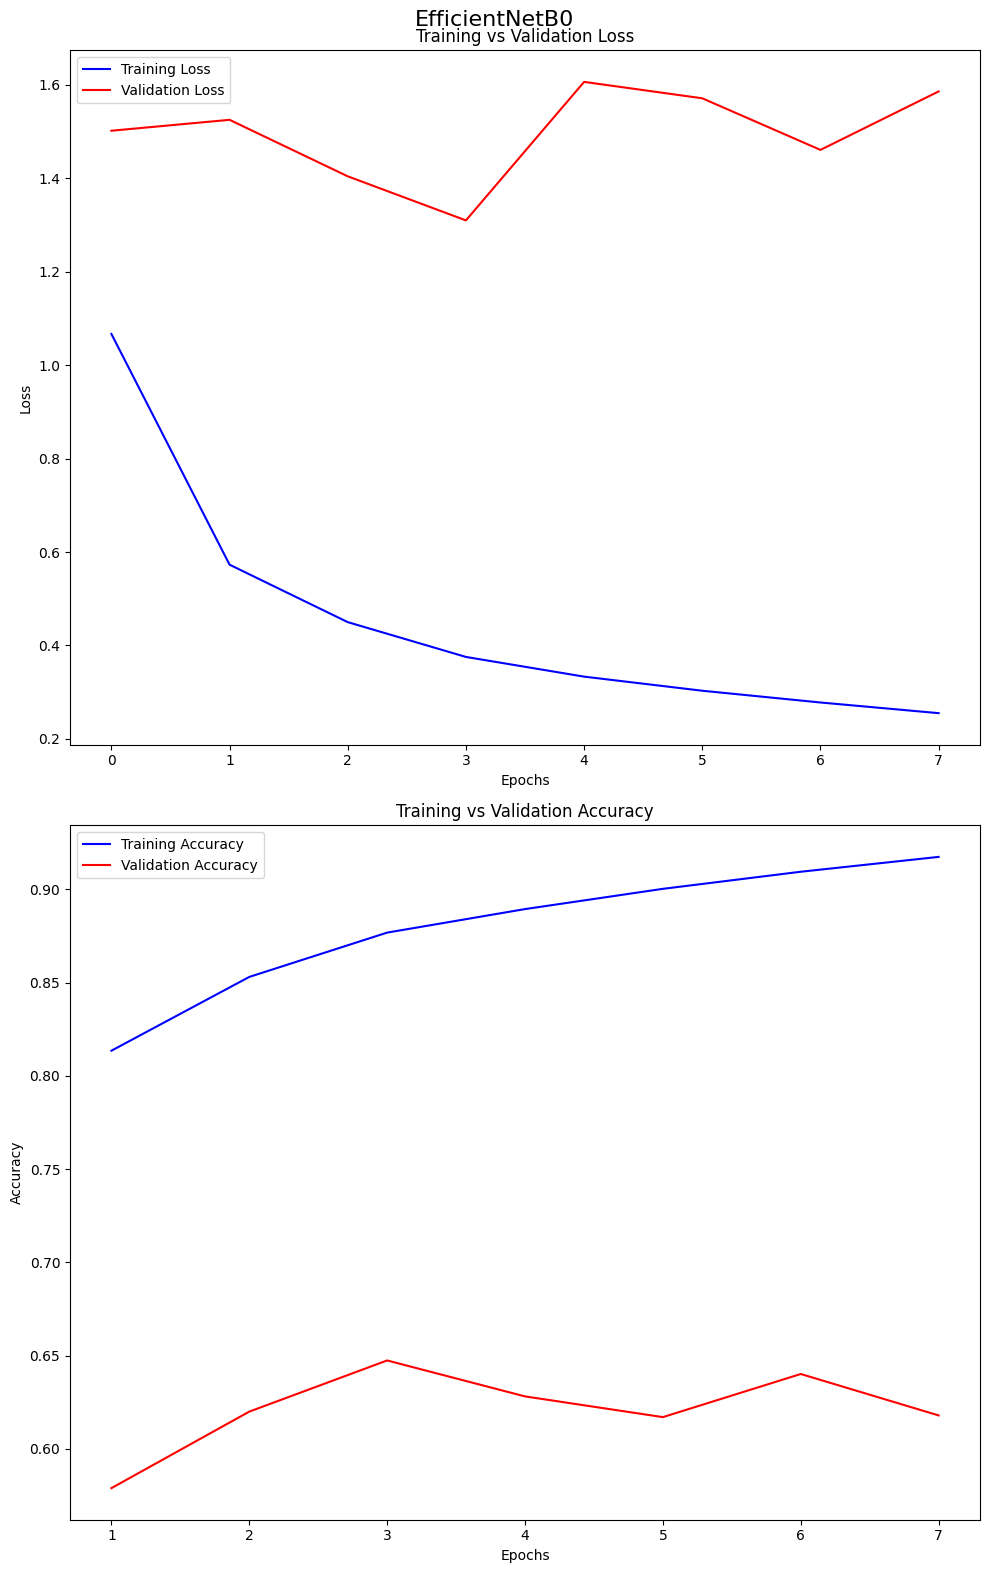

In [44]:
make_graphs(EfficientNetB0_hist, "EfficientNetB0")

In [31]:
# baseline accuracy was about 70%

# add early stopping
# save the best model to current_model.keras

# first, add a dense layer with 64 neurons

EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
EfficientNetB0_base.trainable = False

x = EfficientNetB0_base.output
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                             optimizer="rmsprop",
                             metrics=["accuracy"])


callback= keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='current_model.keras', 
    save_best_only=True, 
    monitor='val_loss', 
    mode='min', 
    verbose=1
)

EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                               batch_size=32,
                                               epochs=10,
                                               validation_data=(X_val, y_val),
                                               callbacks = [callback, model_checkpoint],
                                               verbose=0)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Epoch 1: val_loss improved from inf to 1.77648, saving model to current_model.keras

Epoch 2: val_loss improved from 1.77648 to 1.68355, saving model to current_model.keras

Epoch 3: val_loss improved from 1.68355 to 1.65206, saving model to current_model.keras

Epoch 4: val_loss did not improve from 1.65206

Epoch 5: val_loss did not improve from 1.65206

Epoch 6: val_loss did not improve from 1.65206

Epoch 7: val_loss did not improve from 1.65206

Epoch 8: val_loss did not improve from 1.65206

Epoch 9: val_loss did not improve from 1.65206

Epoch 10: val_loss did not improve from 1.65206


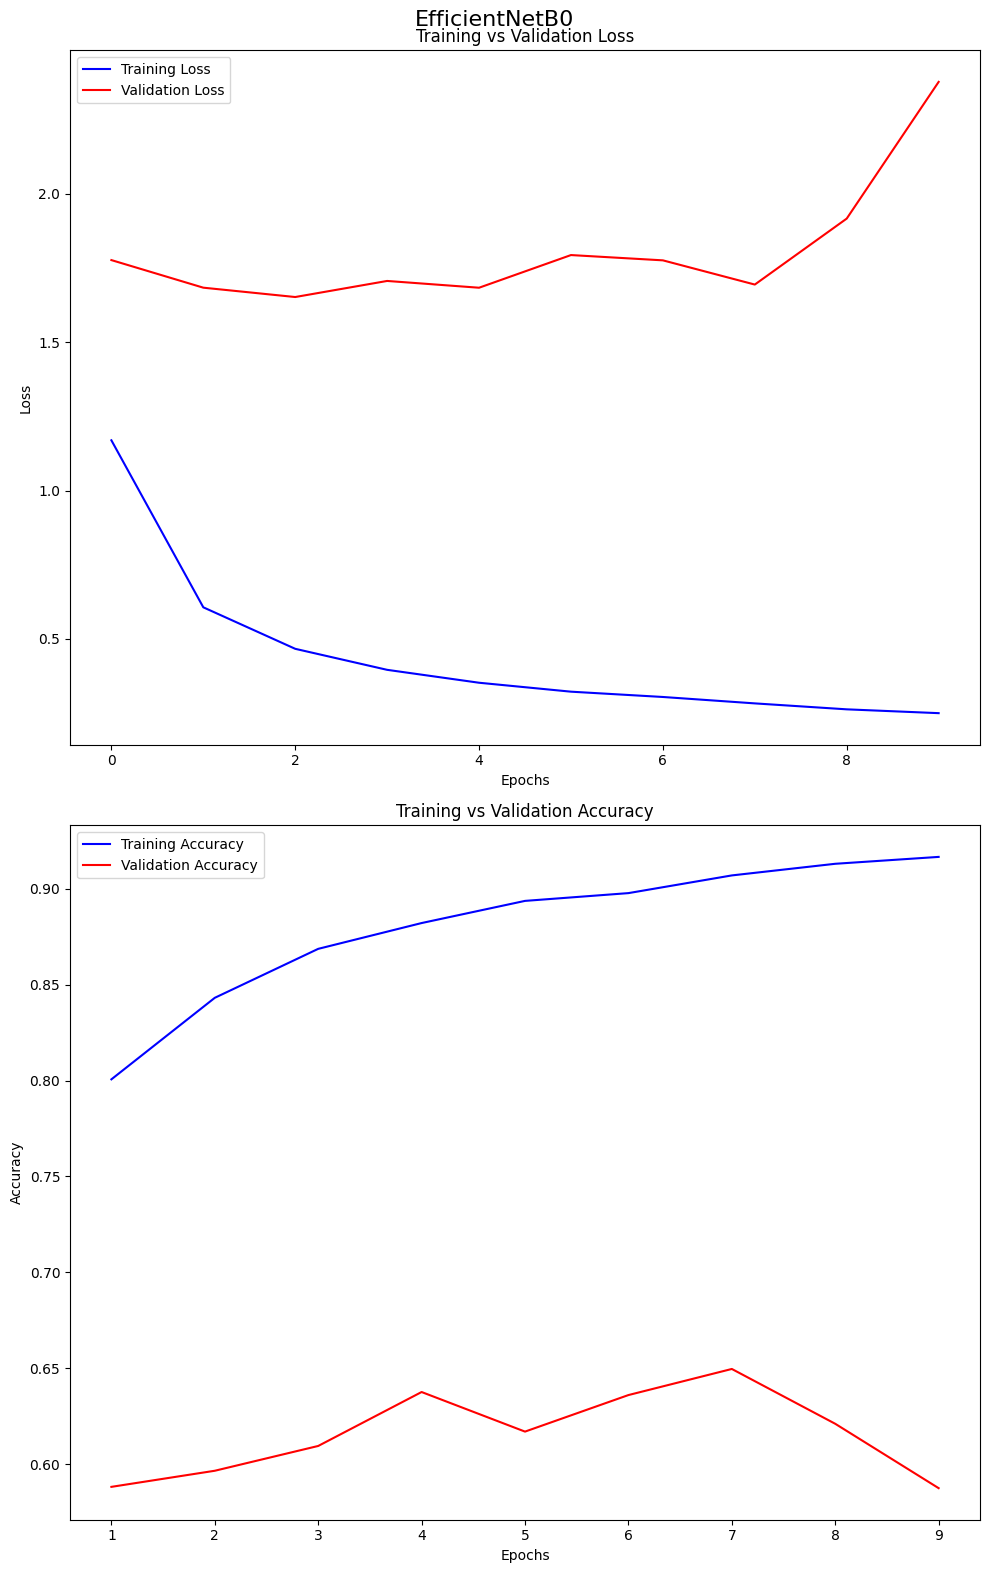

In [32]:
make_graphs(EfficientNetB0_hist, "EfficientNetB0")

In [33]:
# try 128 neurons with 0.5 dropout

EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
EfficientNetB0_base.trainable = False

x = EfficientNetB0_base.output
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                             optimizer="rmsprop",
                             metrics=["accuracy"])


callback= keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='current_model.keras', 
    save_best_only=True, 
    monitor='val_loss', 
    mode='min', 
    verbose=1
)

EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                               batch_size=32,
                                               epochs=10,
                                               validation_data=(X_val, y_val),
                                               callbacks = [callback, model_checkpoint],
                                               verbose=0)



Epoch 1: val_loss improved from inf to 1.53539, saving model to current_model.keras

Epoch 2: val_loss improved from 1.53539 to 1.50756, saving model to current_model.keras

Epoch 3: val_loss improved from 1.50756 to 1.33926, saving model to current_model.keras

Epoch 4: val_loss did not improve from 1.33926

Epoch 5: val_loss improved from 1.33926 to 1.33845, saving model to current_model.keras

Epoch 6: val_loss did not improve from 1.33845

Epoch 7: val_loss did not improve from 1.33845

Epoch 8: val_loss did not improve from 1.33845

Epoch 9: val_loss did not improve from 1.33845

Epoch 10: val_loss did not improve from 1.33845


In [35]:
# try 32 neurons with 0.2 dropout

EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
EfficientNetB0_base.trainable = False

x = EfficientNetB0_base.output
x = layers.Flatten()(x)
x = layers.Dense(32)(x)
x = layers.Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                             optimizer="rmsprop",
                             metrics=["accuracy"])


callback= keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='current_model.keras', 
    save_best_only=True, 
    monitor='val_loss', 
    mode='min', 
    verbose=1
)

EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                               batch_size=32,
                                               epochs=10,
                                               validation_data=(X_val, y_val),
                                               callbacks = [callback, model_checkpoint],
                                               verbose=1)


Epoch 1/10
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4791 - loss: 1.8388
Epoch 1: val_loss improved from inf to 1.46219, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - accuracy: 0.4793 - loss: 1.8380 - val_accuracy: 0.5447 - val_loss: 1.4622
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7342 - loss: 0.8333
Epoch 2: val_loss improved from 1.46219 to 1.38503, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.7342 - loss: 0.8332 - val_accuracy: 0.5803 - val_loss: 1.3850
Epoch 3/10
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7888 - loss: 0.6535
Epoch 3: val_loss improved from 1.38503 to 1.25279, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.7888 - loss: 0.6535 - val_accuracy: 0.6184 - val_loss: 1.2528
Epoch 4/10
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8185 - loss: 0.5650
Epoch 4: val_loss imp

In [36]:
# all 3 performed similarly worse than baseline.
# try training baseline with no changes for longer (with early stopping)

EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
EfficientNetB0_base.trainable = False

x = EfficientNetB0_base.output
x = layers.Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                             optimizer="rmsprop",
                             metrics=["accuracy"])

callback= keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='current_model.keras', 
    save_best_only=True, 
    monitor='val_loss', 
    mode='min', 
    verbose=1
)

EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                               batch_size=32,
                                               epochs=30,
                                               validation_data=(X_val, y_val),
                                               callbacks = [callback, model_checkpoint],
                                               verbose=1)


Epoch 1/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5575 - loss: 1.4956
Epoch 1: val_loss improved from inf to 1.54586, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - accuracy: 0.5576 - loss: 1.4952 - val_accuracy: 0.5753 - val_loss: 1.5459
Epoch 2/30
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8068 - loss: 0.6010
Epoch 2: val_loss improved from 1.54586 to 1.45759, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.8068 - loss: 0.6009 - val_accuracy: 0.6159 - val_loss: 1.4576
Epoch 3/30
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8532 - loss: 0.4493
Epoch 3: val_loss improved from 1.45759 to 1.42926, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.8532 - loss: 0.4493 - val_accuracy: 0.6023 - val_loss: 1.4293
Epoch 4/30
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8777 - loss: 0.3794
Epoch 4: val_loss did

In [39]:
# change early stopping criteria to accuracy

EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
EfficientNetB0_base.trainable = False

x = EfficientNetB0_base.output
x = layers.Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                             optimizer="rmsprop",
                             metrics=["accuracy"])

callback= keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='current_model.keras', 
    save_best_only=True, 
    monitor='val_accuracy', 
    mode='max', 
    verbose=1
)

EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                               batch_size=32,
                                               epochs=30,
                                               validation_data=(X_val, y_val),
                                               callbacks = [callback, model_checkpoint],
                                               verbose=1)


Epoch 1/30
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5603 - loss: 1.4707
Epoch 1: val_accuracy improved from -inf to 0.55374, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - accuracy: 0.5605 - loss: 1.4700 - val_accuracy: 0.5537 - val_loss: 1.5390
Epoch 2/30
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8030 - loss: 0.6180
Epoch 2: val_accuracy improved from 0.55374 to 0.61905, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.8030 - loss: 0.6179 - val_accuracy: 0.6190 - val_loss: 1.4684
Epoch 3/30
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8473 - loss: 0.4636
Epoch 3: val_accuracy did not improve from 0.61905
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.8473 - loss: 0.4636 - val_accuracy: 0.6043 - val_loss: 1.4482
Epoch 4/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8731 - loss: 0.3859
Epoch 4: val_accuracy did not improve from 0.6190

In [48]:
# The intial performance of the baseline is not replicated. 
# Run the baseline model again a few times to see if it was a fluke.
# Switch criteria back to loss, and try different techniques for addressing overfitting.

EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
EfficientNetB0_base.trainable = False

x = EfficientNetB0_base.output
x = layers.Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                             optimizer="rmsprop",
                             metrics=["accuracy"])

EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                               batch_size=32,
                                               epochs=10,
                                               validation_data=(X_val, y_val),
                                               verbose=1)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.5590 - loss: 1.4870 - val_accuracy: 0.5714 - val_loss: 1.5053
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.7974 - loss: 0.6213 - val_accuracy: 0.6200 - val_loss: 1.3474
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.8496 - loss: 0.4568 - val_accuracy: 0.5855 - val_loss: 1.5228
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.8750 - loss: 0.3809 - val_accuracy: 0.6150 - val_loss: 1.5186
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.8928 - loss: 0.3363 - val_accuracy: 0.6399 - val_loss: 1.4566
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.9032 - loss: 0.2985 - val_accuracy: 0.6542 - val_loss: 1.4119
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.9118 - loss: 0.2723 - val_accuracy: 0.6150 - val_loss: 1.5318
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.9159 -

In [49]:
EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
EfficientNetB0_base.trainable = False

x = EfficientNetB0_base.output
x = layers.Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                             optimizer="rmsprop",
                             metrics=["accuracy"])

EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                               batch_size=32,
                                               epochs=10,
                                               validation_data=(X_val, y_val),
                                               verbose=1)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 48s 41ms/step - accuracy: 0.5592 - loss: 1.4787 - val_accuracy: 0.5841 - val_loss: 1.5228
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.8034 - loss: 0.6120 - val_accuracy: 0.5991 - val_loss: 1.3903
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.8484 - loss: 0.4613 - val_accuracy: 0.6195 - val_loss: 1.3758
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.8779 - loss: 0.3769 - val_accuracy: 0.6277 - val_loss: 1.4131
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.8880 - loss: 0.3391 - val_accuracy: 0.6243 - val_loss: 1.4705
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.9015 - loss: 0.2984 - val_accuracy: 0.6415 - val_loss: 1.4260
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.9103 - loss: 0.2664 - val_accuracy: 0.6333 - val_loss: 1.5583
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.9138 -

In [50]:
EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
EfficientNetB0_base.trainable = False

x = EfficientNetB0_base.output
x = layers.Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                             optimizer="rmsprop",
                             metrics=["accuracy"])

EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                               batch_size=32,
                                               epochs=10,
                                               validation_data=(X_val, y_val),
                                               verbose=1)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.5605 - loss: 1.4803 - val_accuracy: 0.5694 - val_loss: 1.5164
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.8012 - loss: 0.6107 - val_accuracy: 0.6168 - val_loss: 1.3953
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - accuracy: 0.8495 - loss: 0.4600 - val_accuracy: 0.6184 - val_loss: 1.4467
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.8778 - loss: 0.3771 - val_accuracy: 0.6265 - val_loss: 1.5019
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - accuracy: 0.8941 - loss: 0.3289 - val_accuracy: 0.6147 - val_loss: 1.5558
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.8988 - loss: 0.3050 - val_accuracy: 0.6472 - val_loss: 1.4579
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.9113 - loss: 0.2698 - val_accuracy: 0.6132 - val_loss: 1.6401
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.9159 -

In [54]:
# Average the max validation accuracy for all 4 runs to establish a more realistic baseline. 
print((0.7290 + 0.6542 + 0.6633 + 0.6578)/4)
print((0.6542 + 0.6633 + 0.6578)/3) # also average 3 runs than are more in line with each other.
# First run seemed to just be lucky. Even still, better than other models I tried in baseline.ipynb

0.676075
0.6584333333333333


In [ ]:
# I'll just go with 66% validation accuracy as the target to beat.
# Overfitting is definitely the first problem to solve.



In [ ]:
# Data Augmentation

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)